## Emotion Detection

#### importing the library

In [17]:
import matplotlib.pyplot as plt
from glob import glob #is used create the list
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print('tensorflow_version', tf.__version__)

tensorflow_version 2.16.1


#### exploring dataset

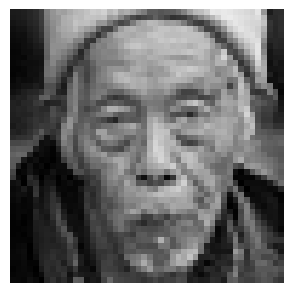

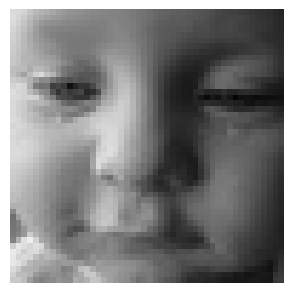

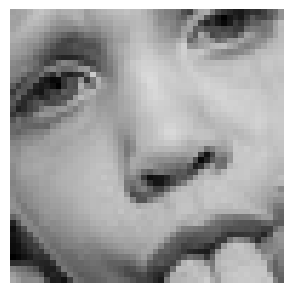

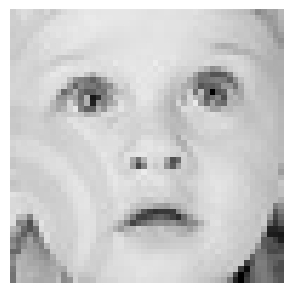

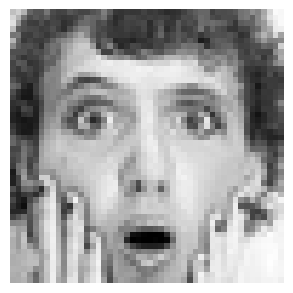

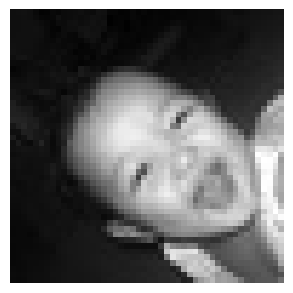

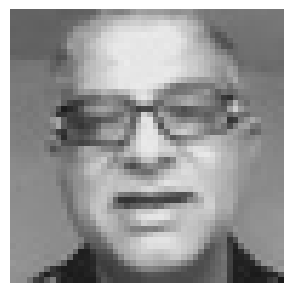

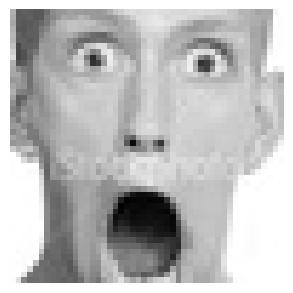

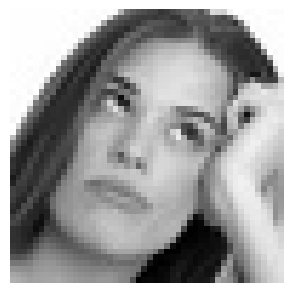

In [21]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,20))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis("off")

In [32]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size= (img_size,img_size),
                                                    color_mode= "grayscale", 
                                                    batch_size = batch_size, 
                                                    class_mode= "categorical", 
                                                    shuffle=True)

datagen_val = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size= (img_size,img_size),
                                                    color_mode= "grayscale", 
                                                    batch_size = batch_size, 
                                                    class_mode= "categorical", 
                                                    shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


*/ Defining model /*

In [41]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding= "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size= (2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [42]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [37]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    conv_3 = Convolution(inputs,128,(3,3))

    flatten = Flatten()(conv_3)

    dense_1  = Dense_f(flatten,256)

    output = Dense(7, activation="softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])

    model.compile(loss = ['categorial_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])

    return model

In [29]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

In [46]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model.weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
callbacks = [checkpoint]

In [47]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/15


C:\Users\MORE SIR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3308 - loss: 1.8011
Epoch 1: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1571s 3s/step - accuracy: 0.3310 - loss: 1.8008 - val_accuracy: 0.3011 - val_loss: 1.6533
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 25:24 3s/step - accuracy: 0.4844 - loss: 1.5145

C:\Users\MORE SIR\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.4844 - loss: 1.5145 - val_accuracy: 0.1000 - val_loss: 2.1037
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4907 - loss: 1.3435
Epoch 3: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 758s 2s/step - accuracy: 0.4907 - loss: 1.3435 - val_accuracy: 0.4339 - val_loss: 1.4907
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 11:29 2s/step - accuracy: 0.5469 - loss: 1.2624
Epoch 4: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5469 - loss: 1.2624 - val_accuracy: 0.7000 - val_loss: 1.4509
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5644 - loss: 1.1662
Epoch 5: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 793s 2s/step - accuracy: 0.5644 - loss: 1.1662 - val_accuracy: 0.4385 - val_loss: 1.5162
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13:30 2s/step - accuracy: 0.5938 - loss: 1.0895
Epoch 6: savi

## Model Evaluation 

In [48]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 289ms/step - accuracy: 0.4852 - loss: 1.5822


[1.6296852827072144, 0.47074395418167114]

## Plotting Loss

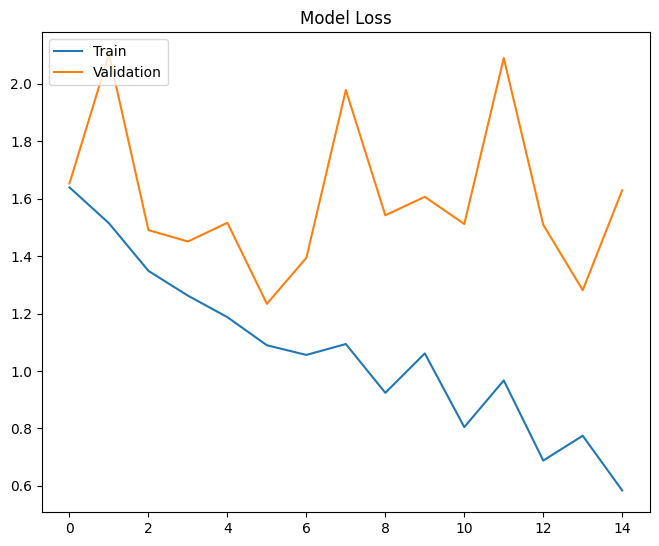

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.legend(["Train","Validation"], loc = "upper left")
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left =0.0, hspace=0.25, wspace = 0.35)

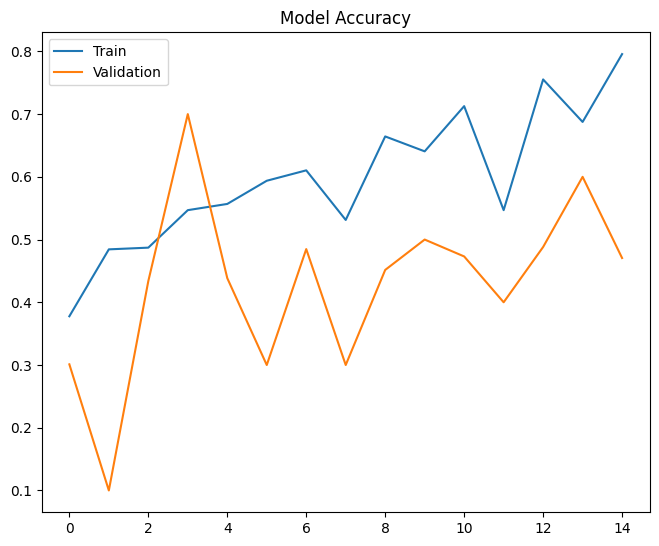

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.legend(["Train","Validation"], loc = "upper left")
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left =0.0, hspace=0.25, wspace = 0.35)

## Saving Model

In [53]:
model_json = model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)